In [ ]:
!pip install gymnasium matplotlib numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 KB 18.3 MB/s eta 0:00:00


In [ ]:
from google.colab import widgets
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import time
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox)
import pickle
import copy
import math

# Env parameters
env_height, env_width = 4,4
no_actions = 4

# Parameters
alpha = 0.3
no_steps = 24

# Parameters I'm tuning
# gamma = 0.5
# no_episodes = 100

In [ ]:
# Reward Dynamics
def plotReward(name, reward_per_episode, no_episodes):
  plt.figure(figsize=(24, 16))
  plt.plot(reward_per_episode, 'ro')
  plt.xlabel('Episode', fontsize=28)
  plt.ylabel('Reward Value', fontsize=28)
  plt.title('Rewards Per Episode (Training) ' + name, fontsize=36)
  plt.xticks(fontsize=24)
  plt.yticks([-10, -5, 0, 5, 10, 15, 20], fontsize=24)
  plt.ylim(ymin=-20, ymax=20)
  plt.xlim(xmin=0, xmax=no_episodes)
  plt.grid()
  plt.show()

In [ ]:
# Epsilon-decay

def plotEpsilonDecay(name, epsilon_values, no_episodes):
  plt.figure(figsize=(10, 8))
  plt.plot(epsilon_values, linewidth=4)
  plt.xlabel('Episode no.', fontsize=24)
  plt.ylabel('Epsilon Values', fontsize=24)
  plt.title('Epsilon Decay ' + name, fontsize=32)
  plt.xticks(fontsize=22)
  plt.yticks(fontsize=22)
  plt.ylim(ymin=0, ymax=1)
  plt.xlim(xmin=0, xmax=no_episodes)
  plt.grid()
  plt.show()


In [ ]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': ["human", "rgb_array"] }

    def __init__(self):
        # Maximum steps before we end the episode
        self.max_timesteps = no_steps
        # Init timestep to 0
        self.timestep = 0

        self.environment_height, self.environment_width = env_height, env_width
        # How much of the environment is visible to the agent
        self.observation_space = spaces.Discrete(1)
        # No of directions the agent can move in
        self.action_space = spaces.Discrete(no_actions)

        # Agent starts at the first box
        self.agent_pos = np.asarray([0, 0])
        # Terminal position is bottom right square
        self.goal_pos = np.asarray([3, 3])
        self.reward_pos = np.asarray([[1,1],[1,3]])
        self.regret_pos = np.asarray([[3,1], [1,2]])


    def reset(self, **kwargs):
        # Reset timesteps, rewards, and agent position
        self.timestep = 0
        self.reward_pos = np.asarray([[1,3],[1,1]])
        self.agent_pos = np.asarray([0, 0])
        # TODO: Am I sending the right observation back?
        observation = 0
        # What's the point of info?
        info = {}
        return observation, info

    def step(self, action, prob):
        # print("ACTION TAKEN", action)
        rand = np.random.random()
        # if prob is not 1, then there's a 1-prob chance of picking a random action
        if rand > prob:
          # Generate a number between 0 and action_space(8)
          old_action = action
          action = np.random.randint(0, self.action_space.n)
          # print("ACTION INTENDED VS TAKEN", old_action, action)

        # 4 possible actions in all directions
        if action == 0:
          # Move right (up)
          self.agent_pos[1] += 1
        if action == 1:
          # Move down (right)
          self.agent_pos[0] += 1
        if action == 2:
          # Move left (down)
          self.agent_pos[1] -= 1
        if action == 3:
          # Move up (left)
          self.agent_pos[0] -= 1


        # Comment this to demonstrate the truncation condition.
        self.agent_pos = np.clip(self.agent_pos, 0, 3)

        # Agent's current position
        observation = self.agent_pos[0] * 4 + self.agent_pos[1]
        info = {}
        reward = 0

        terminated = False
        # If the agent reached the goal, reward is 10 and terminated is true.
        if np.array_equal(self.agent_pos, self.goal_pos):
          reward = 10
          terminated = True

        # Else if it reaches a trap
        elif  any(np.array_equal(self.regret_pos[i], self.agent_pos) for i in range(len(self.regret_pos))):
          reward = -5
        # Else if it reaches the reward
        else:
          for i in range(len(self.reward_pos)):
            if np.array_equal(self.agent_pos, self.reward_pos[i]):
              self.reward_pos = np.delete(self.reward_pos, i, axis=0)
              reward = 3
              break

        # Increment timestep
        self.timestep += 1

        terminated = True if self.timestep >= self.max_timesteps else terminated
        truncated = True if np.all((self.agent_pos >=0 ) & (self.agent_pos <= 3)) else False

        return observation, reward, terminated, truncated, info

    def render(self):
        # first of all, the base transformation of the data points is needed
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xlim(0,self.environment_width)
        ax.set_ylim(0,self.environment_height)
        print("CURRENT AGENT POSITION", self.agent_pos)
        def plot_image(plot_pos):
          plot_agent, plot_reward, plot_goal, plot_regret = False, False, False, False

          # Figuring out what to plot
          if np.array_equal(self.agent_pos, plot_pos):
            plot_agent = True
          if any(np.array_equal(self.reward_pos[i], plot_pos) for i in range(len(self.reward_pos))):
              plot_reward = True
          if any(np.array_equal(self.regret_pos[i], plot_pos) for i in range(len(self.regret_pos))):
            plot_regret = True
          if np.array_equal(self.goal_pos, plot_pos):
            plot_goal = True

          # # Actually plotting
          if plot_agent and plot_regret:
            mouseintrap = AnnotationBbox(OffsetImage(plt.imread('./mouseandtrap.jpg'), zoom=.8),
            np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(mouseintrap)
          elif plot_agent and plot_reward:
            mousewithcheese = AnnotationBbox(OffsetImage(plt.imread('./mouseandcheese.jpg'), zoom=1),
            np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(mousewithcheese)
          elif plot_agent and plot_goal:
            agentatgoal = AnnotationBbox(OffsetImage(plt.imread('./mouseandgold.jpg'), zoom=.8),
            np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(agentatgoal)
          elif plot_agent:
            agent = AnnotationBbox(OffsetImage(plt.imread('./mouse.jpg'), zoom=0.3),
                                    np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(agent)
          elif plot_regret:
            regret = AnnotationBbox(OffsetImage(plt.imread('./mousetrap.jpg'), zoom=1),
                                    np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(regret)
          elif plot_reward:
            reward = AnnotationBbox(OffsetImage(plt.imread('./cheese.jpg'), zoom=0.5),
                                    np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(reward)
          elif plot_goal:
            goal = AnnotationBbox(OffsetImage(plt.imread('./gold.jpg'), zoom=1.2),
                                    np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(goal)

        coordinates_state_mapping = {}
        for j in range(self.environment_height * self.environment_width): # j iterates 16 times (0 - 15)
          coordinates_state_mapping[j] = np.asarray([j % self.environment_width, int(np.floor(j/ self.environment_width))])

        for position in coordinates_state_mapping:
          plot_image(coordinates_state_mapping[position])

        plt.xticks([0,1,2,3])
        plt.yticks([0,1,2,3])
        plt.grid()
        plt.show()


        # plt.imshow(self.state)

In [ ]:
class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, obs, Qt, ep):
    # Choose action A from from state S using policy derived from Q
    # Generate random number, if lesser than epsilon - Random action
    rand = np.random.random()
    if rand < ep:
      # print("Taking random action, rand, epsilon",rand, ep)
      return np.random.choice(self.action_space.n)
    #Else Best action - look at Q table and see which action has the best Q value for current state (or observation)
    else:
      # Taking the action that has highest Q value for the curresnt state (obs)
      # print("Taking greedy action")
      return np.argmax(Qt[obs])



In [ ]:
env = GridEnvironment()
agent = RandomAgent(env)

In [ ]:
def driver(gamma, no_episodes, name):
  # output_grid = widgets.Grid(1, 1)

  # prob 1 for deterministic, anything else between [0-1) for stochastic
  prob = 0.98
  episode = 0
  reward_per_episode = []
  # All epsilon values through different episodes
  epsilon_values = []

  # Initialize Q(s,a) table
  Qt = np.zeros((env_height * env_width, no_actions))
  # This keeps all Q tables generated at the end of each episode
  pickle_feeder = {"initial": copy.deepcopy(Qt)}
  epsilon = 1
  # Loop for multiple episodes.
  for episode in range(no_episodes):
    ep = "episode_" + str(episode)
    obs, info = env.reset()
    episode_reward = 0
    terminated, truncated = False, False
    epsilon = epsilon * 0.998
    epsilon_values.append(epsilon)
    while not terminated:
      old_state = obs
      action = agent.step(old_state, Qt, epsilon )
      obs, reward, terminated, truncated, info = env.step(action, prob)
      # Update Q table
      Qt[old_state][action] = Qt[old_state][action] + alpha * (reward + gamma * max(Qt[obs]) - Qt[old_state][action])
      # print("EPISODE REWARD UPDATE {0} += {1}".format(episode_reward, reward))
      episode_reward += reward
      # with output_grid.output_to(0, 0):
      #   output_grid.clear_cell()
      #   env.render()
      # time.sleep(1)

    reward_per_episode.append(episode_reward)
    # if episode %100 == 0:print("Epsilon after episode {0}: {1}".format(episode ,epsilon ))
    # printQt(Qt)
    pickle_feeder[ep] = copy.deepcopy(Qt)

  print("# Episodes {0}, gamma {1}, Qtable: \n{2}".format(no_episodes, gamma, Qt))
  with open('Qt_'+name+'.pickle', 'wb') as f:
    pickle.dump(pickle_feeder, f)
  print("TOTAL REWARD: \n", reward_per_episode[-10:], terminated)
  return (epsilon_values, reward_per_episode)



# Episodes 3000, gamma 0.9, Qtable: 
[[ 5.45765367  8.30129103  6.74180248  6.64814883]
 [ 8.15583359  5.71249995  5.7866848   5.71226329]
 [ 9.5506215   3.15583099  6.15751702  6.19168595]
 [ 6.59511666 10.89159277  6.47881271  6.66758192]
 [ 9.27231864  5.91561122  6.81668182  6.7123148 ]
 [ 4.03790012  7.12421956  6.13287572  5.12820835]
 [11.10019609  7.98746332  7.4532672   7.95418065]
 [ 6.45025247  9.03642881  3.19136397  6.59466255]
 [ 7.05705084  5.75459187  5.9792791   6.05362133]
 [ 8.05702409  2.4168151   6.53420685  6.25613881]
 [ 8.99999846  7.53267913  6.99787713  3.4954689 ]
 [ 8.98508071  9.99999991  7.95949278  8.08417523]
 [ 3.06732151  5.90289247  6.04228471  6.22820799]
 [ 8.94549049  3.16127825  5.95839252  7.17343941]
 [10.          8.32296287  3.40474804  7.64847615]
 [ 0.          0.          0.          0.        ]]
TOTAL REWARD: 
 [13, 13, 13, 13, 13, 13, 13, 13, 13, 13] True


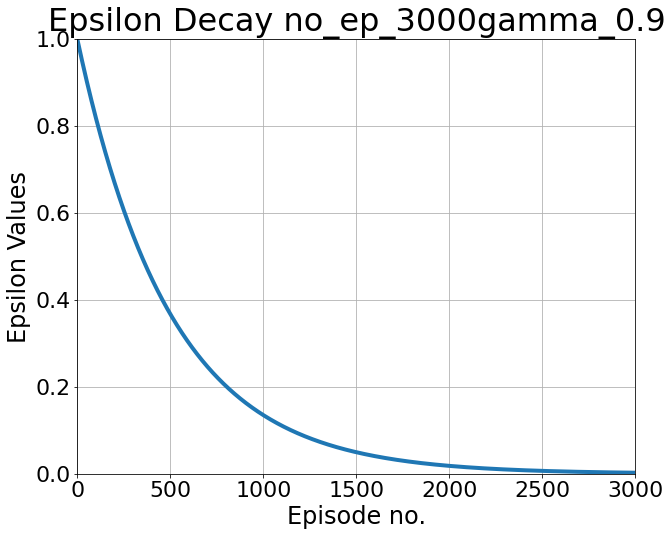

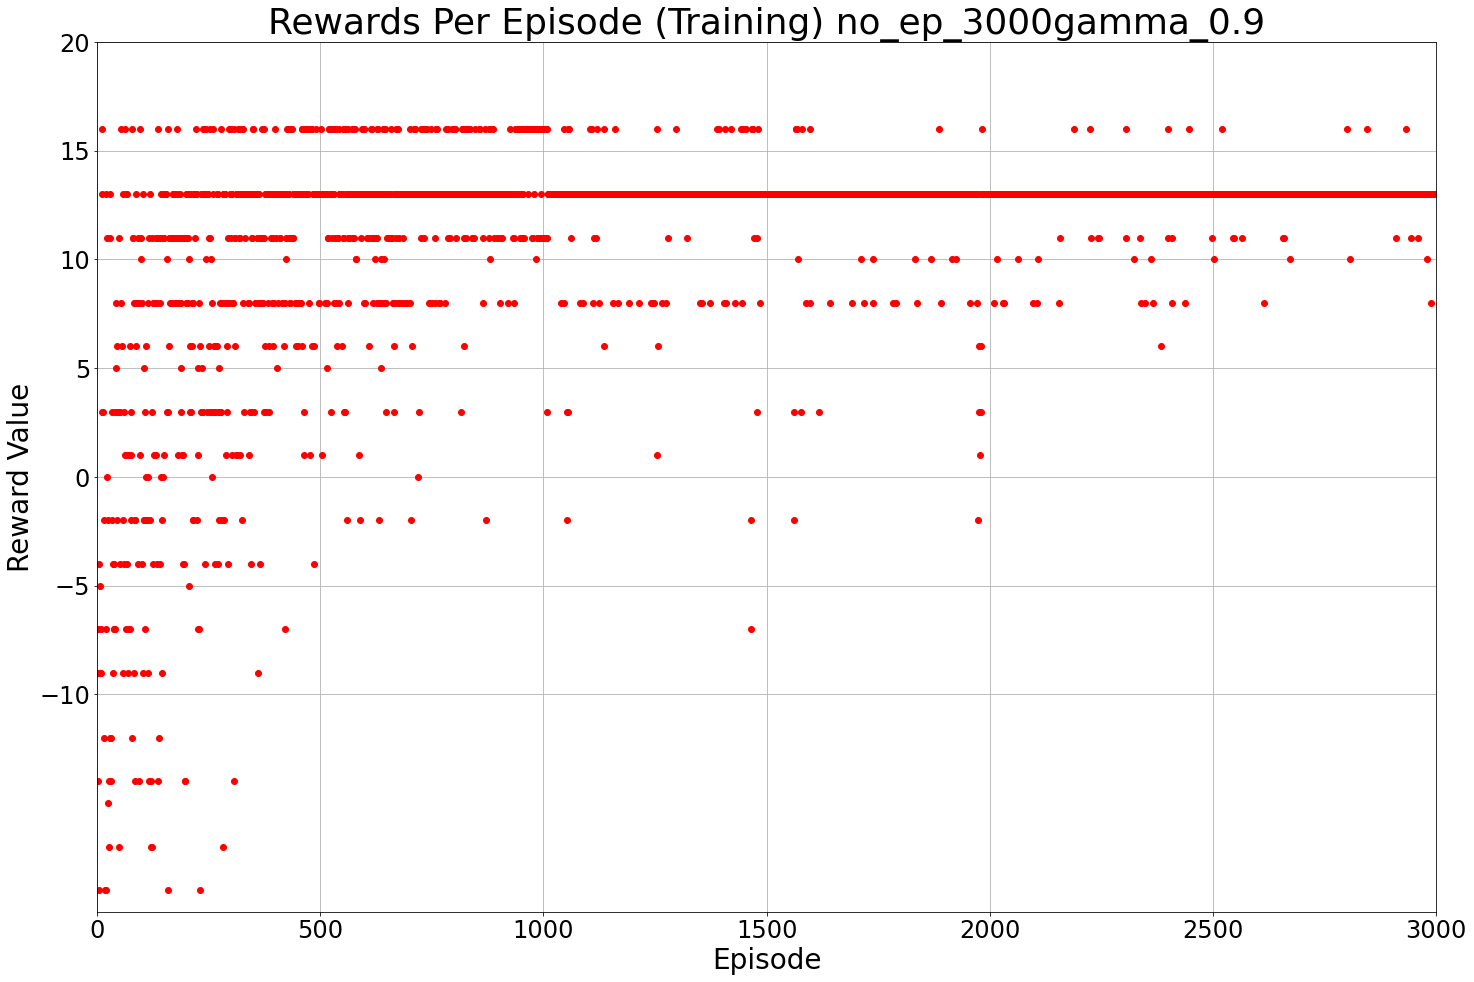

In [ ]:
data = [[0.9, 3000]]
for pair in data:
  gamma = pair[0]
  no_ep = pair[1]
  name = "no_ep_" + str(no_ep) + "gamma_" + str(gamma)
  epsilon_values, reward_per_episode = driver(gamma, no_ep, name)
  plotEpsilonDecay(name, epsilon_values, no_ep)
  plotReward(name, reward_per_episode, no_ep)

In [ ]:
# with open('Qt_no_ep_50gamma_0.9.pickle', 'rb') as f:
#   my_dict = pickle.load(f)
# print(my_dict["episode_49"][8])

In [ ]:
# Images from
#All of these are free for non-commercial use
# https://lovepik.com/images/png-animal.html
# https://www.cleanpng.com/png-mousetrap-trapping-clip-art-mouse-trap-646405/download-png.html
# http://clipart-library.com/img/1734718.gif


# https://docs.python.org/3/library/pickle.html
# https://docs.python.org/3/library/copy.html

In [ ]:
print(reward_per_episode)

[-7, -7, -14, -9, -4, -19, -9, -5, -9, -7, 3, 16, 13, 3, -32, -12, -2, -35, -19, 13, -19, -7, 0, 11, -2, -15, -14, -17, 11, 13, -12, -14, -12, -2, 3, -4, -9, -7, -7, -4, 3, -7, 8, 5, -2, 6, 3, 3, 3, -17, 11, -4, 3, 8, 16, -24, 6, -9, -2, 13, 3, -4, 16, 1, -7, 13, 13, 1, -4, -9, -27, -7, 1, -7, 6, 1, -2, 3, 16, -12, 11, 11, 8, -9, -2, -14, -2, 13, 6, 8, 8, 11, -4, -24, 8, -14, 16, 1, 11, 10, 8, -4, -9, 13, -2, 5, -2, -7, 3, 0, 6, -2, -2, 0, 8, -9, 11, -14, -2, 13, -14, -17, -17, 3, 11, -4, 8, 1, 8, 8, 1, 11, 11, 1, 8, -4, -14, 16, -12, 11, -4, 8, 11, 0, 13, -2, -9, 0, 11, 11, 13, 1, 13, 13, 13, 13, 3, 10, -19, 3, 16, 11, 6, 11, 8, 8, 11, 8, 11, 11, 13, 13, 13, 13, 8, 11, 8, 11, 8, 16, 13, 11, 1, 8, 8, 13, 11, 3, 8, 5, 1, 11, -4, 1, -4, 11, -14, -14, 11, 8, 13, 11, 13, 11, 8, 10, -5, 13, 3, 6, 13, 3, 8, 6, -2, -2, 8, 13, 13, 13, 11, 13, 16, -2, 13, 5, 1, -7, 8, -7, 6, -19, 13, 3, 13, 3, 5, 3, 16, 13, 16, 13, -4, 13, 10, 16, 13, 3, 13, 13, 11, 6, 11, 16, 3, 10, 3, 0, 8, 16, 13, 6, 3, 3, -

In [ ]:
|